# Derivatives Pricing & Risk Management Project
#### Done by: Jordan Sim 1001510

In [1]:
from scipy.stats import norm
from scipy.special import comb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

### Part 1: Construct Binomial Model 

In [2]:
def Binomial(Option,K, T, S, v, r, q, N, Exercise):
    # all values entered should be float
    deltaT=T/N
    u=np.exp(v*np.sqrt(deltaT))
    d=1.0/u
    p=(np.exp((r-q)*deltaT)-d)/(u-d)
    fNj_list=[]
    summ=0.0
    for j in range(N+1): #j is number of moves up in the stock price
        sNj=(u**j)*(d**(N-j))*S
        if Option == 'C':
            fNj=max(sNj-K,0)
        else:
            fNj=max(K-sNj,0)
        fNj_list.append(fNj)
        summ+=comb(N,j)*(p**j)*((1-p)**(N-j))*fNj
    
    eur=summ*np.exp(-r*(T)) 
    if Exercise=='E':
        return eur
    elif Exercise=='A': 
        for i in range(N-1,-1,-1):
            for j in range(i+1):   #j is number of moves up in the stock price
                snj=(u**j)*(d**(i-j))*S
                if Option == 'C':
                    fnj=max(snj-K,0)
                    fNj_list[j]=max(fnj,(p*fNj_list[j+1]+(1-p)*(fNj_list[j]))*np.exp(-r*deltaT))
                else:
                    fnj=max(K-snj,0)
                    fNj_list[j]=max(fnj,(p*fNj_list[j+1]+(1-p)*(fNj_list[j]))*np.exp(-r*deltaT))
        f0=fNj_list[0]
    return f0

In [3]:
def blackScholes(Option,K, T, S, v, r, q, Exercise):
    left=np.log(float(S)/K)
    right= (r-q +0.5*(v**2))*T
    d1=(left+right)/(v*(T**0.5))
    d2=d1-(v*T**0.5)
    if Exercise=='E':
        if Option=='C':
            return S*norm.cdf(d1)*np.exp(-q*T) - K*norm.cdf(d2)*np.exp(-r*T)
        elif Option=='P':
            return -S*norm.cdf(-d1)*np.exp(-q*T) + K*norm.cdf(-d2)*np.exp(-r*T) 

### Part 2
#### 2.1 Price of european call option using Black Scholes Model

In [14]:
%%time
print "European Call Price given by BSM: " + str(blackScholes('C',100,1.0,100,0.2,0.05,0.04,'E'))+'\n'

European Call Price given by BSM: 8.10264353446

CPU times: user 661 µs, sys: 275 µs, total: 936 µs
Wall time: 707 µs


#### 2.2 Visualize the convergence
##### Plot n against the call option price given by Binomial. It indeed convergences to the Black Scholes option price at large n=1000.

In [13]:
%%time
x_list=[]
for n in range(1,200):
    x= Binomial('C',100,1.0,100,0.2,0.05,0.04,n,'E')
    x_list.append(x)

print "Call Price converges at: " + str(Binomial('C',100,1.0,100,0.2,0.05,0.04,1000,'E'))+'\n'

Call Price converges at: 8.10073766064

CPU times: user 245 ms, sys: 15 ms, total: 260 ms
Wall time: 252 ms


CPU times: user 62.1 ms, sys: 9.18 ms, total: 71.3 ms
Wall time: 65.3 ms


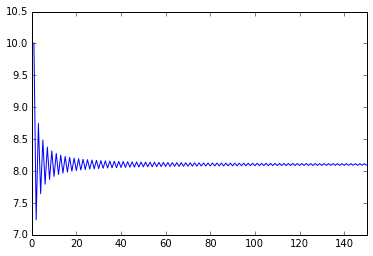

In [6]:
%%time
plt.xlim(0,150)
plt.plot(range(1,200),x_list)

### Part 3: American put option

#### 3.1 Calculate and plot the put value as a function of the initial stock price

In [7]:
%%time
list1=[]
list2=[]
start = 600
stop =1500

for S in [x*0.1 for x in range(start,stop)]:
    Aput= Binomial(Option='P',K=100,T=1.0,S=S,v=0.2,r=0.05,q=0.0,N=12,Exercise='A')
    list1.append(Aput)
    Eput= Binomial(Option='P',K=100,T=1.0,S=S,v=0.2,r=0.05,q=0.0,N=12,Exercise='E')
    list2.append(Eput)

CPU times: user 532 ms, sys: 13.2 ms, total: 545 ms
Wall time: 537 ms


Black line is American Put option payoff as a function of initial stock price S.
Blue line is European Put option payoff.

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


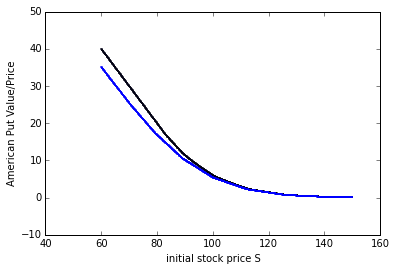

In [8]:
plt.ylabel('American Put Value/Price')
plt.xlabel('initial stock price S')
plt.scatter([x*0.1 for x in range(start,stop)],list1,s=0.5)
plt.scatter([x*0.1 for x in range(start,stop)],list2,s=0.5,color='blue')
plt.show()

In the plot above, as S increases, put option price decreases. This validates the option value function where S and P are inversely proportional. 

Value of american option is the same as its payoff. American option must be worth at least its corresponding
intrinsic value, or european option value.

#### 3.2 What is the initial stock price 𝑆∗(12) for which it first becomes optimal to early exercise the put option?

At last time step S*(12) = K = 100. 

#### 3.3 Report and plot theresulting early exercise boundary 𝑆∗(𝑖) as a function of the option maturity 𝑇=𝑖/12.

In [9]:
def getBoundary(K,S,N,q,stepsize,Option):
    df = pd.DataFrame()
    for time in range(12,-1,-1):
        t=12-time
        T=t/12.0
        if Option=='C':
            AC= Binomial(Option,K,T,S,0.2,0.05,q,N,'A')
            for i in stepsize:
                while S-K-AC<0.0:
                    AC= Binomial(Option,K,T,S,0.2,0.05,q,N,'A')
                    S+=i
                if i!=stepsize[-1]:
                    S-=i  
        elif Option=='P':
            AP= Binomial(Option,K,T,S,0.2,0.05,q,N,'A')
            for i in stepsize:
                while K-S-AP<0.0:
                    AP= Binomial(Option,K,T,S,0.2,0.05,q,N,'A')
                    S-=i
                if i!=stepsize[-1]:
                    S+=i
        df=df.append({'i':time,'T': 1-T,'S*(i)':S},ignore_index=True)
    return df

Time step N used is 200. By using N<200, the results will not be accurate.

By varying how much S decreases at each time, we can get to the optimal early exercise price S* fast. I tried different stepsizes for the decrement and chose the stepsize that provides less computation time without compromising on accuracy.

stepsize_list=[0.5,0.1,0.005] uses 3 mins

stepsize_list=[0.1,0.05,0.005] uses 2.5 mins, and produces same results.

In [10]:
%%time
stepsize_list=[0.1,0.05,0.005]

df=getBoundary(100,100.5,200,0.0,stepsize_list,'P')
display(df)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,S*(i),T,i
0,99.995,1.000000,12.0
1,91.320,0.916667,11.0
2,88.910,0.833333,10.0
3,87.350,0.750000,9.0
4,86.205,0.666667,8.0
5,85.270,0.583333,7.0
6,84.500,0.500000,6.0
7,83.855,0.416667,5.0
8,83.290,0.333333,4.0
9,82.775,0.250000,3.0


CPU times: user 2min 19s, sys: 1.57 s, total: 2min 21s
Wall time: 2min 21s


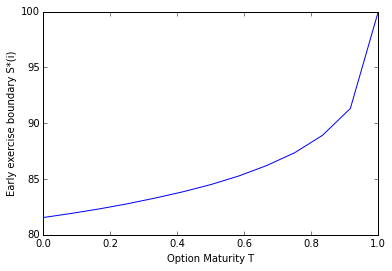

In [11]:
plt.plot(df['T'], df['S*(i)'])
plt.ylabel('Early exercise boundary S*(i)')
plt.xlabel('Option Maturity T')
plt.show()

#### 3. 4 How do put prices and the early exercise boundary change when the continuous dividend yield is 𝑞 = 0.04? 

In [15]:
list3=[]
for S in [x*0.1 for x in range(start,stop)]:
    Aput= Binomial(Option='P',K=100,T=1.0,S=S,v=0.2,r=0.05,q=0.04,N=12,Exercise='A')
    list3.append(Aput)

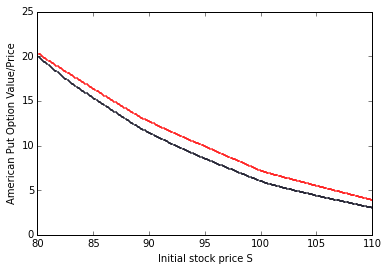

In [16]:
plt.ylabel('American Put Option Value/Price')
plt.xlabel('Initial stock price S')
plt.xlim(80,110)
plt.ylim(0,25)
plt.scatter([x*0.1 for x in range(start,stop)],list1,s=0.5)
plt.scatter([x*0.1 for x in range(start,stop)],list3,s=0.5,color='red')
plt.show()

As initial stock price S increase, put option price decreases. 

Put price with dividend is higher than without dividend. Put price with continuous dividend yield q=0.04 is shown as the red curve. 

decrement_list=[0.5,0.1,0.005] uses 4 mins 10s

decrement_list=[0.1,0.05,0.005] uses 3 mins 40s, and produces same results

In [17]:
%%time
decrement_list=[0.1,0.05,0.005]
df1=getBoundary(100,100.5,200,0.04,decrement_list,'P')
display(df1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,S*(i),T,i
0,99.995,1.000000,12.0
1,88.875,0.916667,11.0
2,85.475,0.833333,10.0
3,83.250,0.750000,9.0
4,81.490,0.666667,8.0
5,80.115,0.583333,7.0
6,78.945,0.500000,6.0
7,77.930,0.416667,5.0
8,77.060,0.333333,4.0
9,76.300,0.250000,3.0


CPU times: user 3min 36s, sys: 2.64 s, total: 3min 38s
Wall time: 3min 43s


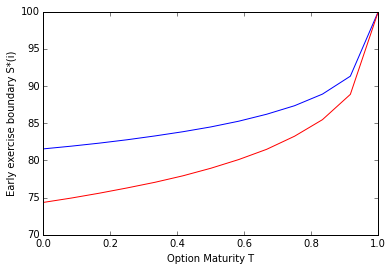

In [18]:
plt.ylabel('Early exercise boundary S*(i)')
plt.xlabel('Option Maturity T')
plt.plot(df['T'], df['S*(i)'])
plt.plot(df1['T'], df1['S*(i)'],color='red')
plt.show()

With dividend, the optimal exercise boundary is always lower.

#### 3.5 What is the intuition behind this dependence on the dividend yield?

The red line is the put option with dividend yield. The optimal early exercise boundary of an american put option with continuous dividend yield is always less than that of an option without dividend. With continuous dividend yield, put  price increases, since the actual stock value is worth less. 

Based on K-S-put value=0, if put value increases, the boundary S* decreases.
Hence, with dividend, the optimal exercise boundary is always lower.

The two boundaries converges as option approaches maturity. This is because as option maturity approaches, the dividends are accounted for and the stock is worth less. With time, the price of american put option with dividend decreases at an increasing rate. 

### Part 4: American Call Option

#### 4.1 Calculate and plot American call values as a function of the initial stock price

In [19]:
%%time
list4=[]
start1 = 0
stop1 =1500

for S in [x*0.1 for x in range(start1,stop1)]:
    Acall= Binomial(Option='C',K=100,T=1.0,S=S,v=0.2,r=0.05,q=0.04,N=12,Exercise='A')
    list4.append(Acall)

CPU times: user 660 ms, sys: 39.4 ms, total: 700 ms
Wall time: 677 ms


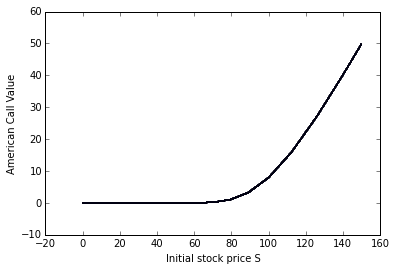

In [20]:
plt.ylabel('American Call Value')
plt.xlabel('Initial stock price S')
plt.scatter([x*0.1 for x in range(start1,stop1)],list4,s=0.5)
plt.show()

#### 4.2 with one month interval, find the initial stock prices 𝑆*(𝑖) for which it first becomes optimal to early exercise the call

increment_list=[2,0.5,0.05,0.005] takes 9 mins 

increment_list=[2,0.5,0.01,0.005] takes 8.5 mins

increment_list=[1,0.5,0.01,0.005] takes 7 mins and produces same results.

this is for N=200. code will run for 1 min if N=100 but accuracy of results decreases.

In [21]:
%%time
increment_list=[1,0.5,0.01,0.005]
df2=getBoundary(100,99,200,0.04,increment_list,'C')
display(df2)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,S*(i),T,i
0,100.000,1.000000,12.0
1,125.055,0.916667,11.0
2,128.705,0.833333,10.0
3,132.235,0.750000,9.0
4,135.430,0.666667,8.0
5,138.235,0.583333,7.0
6,140.685,0.500000,6.0
7,143.000,0.416667,5.0
8,145.065,0.333333,4.0
9,147.025,0.250000,3.0


CPU times: user 6min 57s, sys: 4.98 s, total: 7min 2s
Wall time: 7min 4s


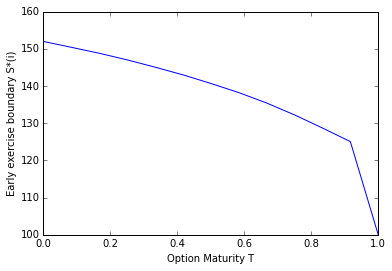

In [22]:
plt.ylabel('Early exercise boundary S*(i)')
plt.xlabel('Option Maturity T')
plt.plot(df2['T'], df2['S*(i)'])
plt.show()

#### 4.3 How do call prices and the early exercise boundary change when the continuous dividend yield is 𝑞 = 0.08?

In [23]:
list5=[]

for S in [x*0.1 for x in range(start1,stop1)]:
    Acall= Binomial(Option='C',K=100,T=1.0,S=S,v=0.2,r=0.05,q=0.08,N=12,Exercise='A')
    list5.append(Acall)

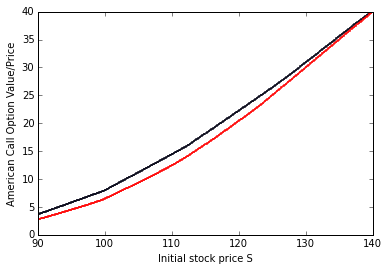

In [24]:
plt.ylabel('American Call Option Value/Price')
plt.xlabel('Initial stock price S')
plt.xlim(90,140)
plt.ylim(0,40)
plt.scatter([x*0.1 for x in range(start1,stop1)],list4,s=0.5)
plt.scatter([x*0.1 for x in range(start1,stop1)],list5,s=0.5,color='red')
plt.show()

Red curve is option price with dividend q=0.08.

As dividend is doubled, call price is lower at every initial stock price S.

In [25]:
%%time
increment_list=[1,0.5,0.01,0.005]
df3=getBoundary(100,98,200,0.08,increment_list,'C')
display(df3)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,S*(i),T,i
0,100.000,1.000000,12.0
1,110.530,0.916667,11.0
2,113.935,0.833333,10.0
3,116.265,0.750000,9.0
4,118.045,0.666667,8.0
5,119.515,0.583333,7.0
6,120.770,0.500000,6.0
7,121.830,0.416667,5.0
8,122.775,0.333333,4.0
9,123.645,0.250000,3.0


CPU times: user 3min, sys: 2.18 s, total: 3min 3s
Wall time: 3min 6s


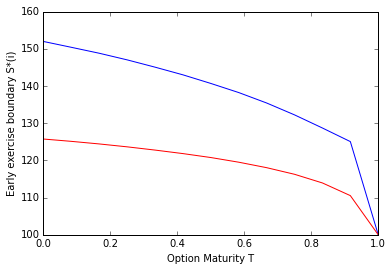

In [26]:
plt.ylabel('Early exercise boundary S*(i)')
plt.xlabel('Option Maturity T')
plt.plot(df2['T'], df2['S*(i)'])
plt.plot(df3['T'], df3['S*(i)'],color='red')
plt.show()

With higher dividend yield, early exercise boundary S*(i) is lower. 

#### 4.4 What is the intuition behind this dependence on the dividend yield?

The red line is the call option with doubled dividend yield. The optimal early exercise boundary of an american call option with higher dividend yield is always less than that of an option with lesser dividend yield. With higher dividends, since actual value of stock is less, call option price with q=0.08 is lower than that of q=0.04.

To ensure S-K-American Call Price=0 is held, as call price is lowered, boundary S* is also lowered.

The two boundaries converges as option approaches maturity. This is because as option maturity approaches, call prices with q=0.04 decreases at an increasing rate. 